In [3]:
%config Completer.use_jedi = False

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import shap

from sklearn.preprocessing import StandardScaler

import optuna.integration.lightgbm as lgbm
import optuna


import warnings
warnings.filterwarnings('ignore')

import wandb

plt.rcParams.update({'font.size': 18})
plt.style.use('ggplot')

In [79]:
train = pd.read_csv('./widsdatathon2022/train.csv')
test = pd.read_csv('./widsdatathon2022/test.csv')

train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [81]:
print(train.State_Factor.unique())
print(test.State_Factor.unique())

['State_1' 'State_2' 'State_4' 'State_6' 'State_8' 'State_10' 'State_11']
['State_1' 'State_2' 'State_4' 'State_8' 'State_11' 'State_10']


In [4]:
train.describe()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,7.575700e+04,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,1.659839e+05,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,...,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,2.468758e+05,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,...,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,6.237900e+04,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,...,72.000000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,88.000000,54.528601,18939.000000
50%,5.000000,9.136700e+04,1951.000000,67.000000,25.000000,11.000000,34.451613,59.000000,9.000000,34.107143,...,84.000000,12.000000,0.000000,0.000000,1.000000,1.000000,1.000000,104.000000,75.293716,37878.000000
75%,6.000000,1.660000e+05,1977.000000,85.000000,42.700000,13.000000,37.322581,62.000000,20.000000,40.879310,...,97.000000,17.000000,0.000000,0.000000,1.000000,1.000000,1.000000,131.000000,97.277534,56817.000000
max,6.000000,6.385382e+06,2015.000000,100.000000,1924.500000,49.000000,64.758065,91.000000,48.000000,65.107143,...,260.000000,185.000000,119.000000,16.000000,360.000000,360.000000,23.300000,311.000000,997.866120,75756.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [7]:
train.isnull().sum()/len(train)*100

Year_Factor                   0.000000
State_Factor                  0.000000
building_class                0.000000
facility_type                 0.000000
floor_area                    0.000000
                               ...    
direction_peak_wind_speed    55.190939
max_wind_speed               54.228652
days_with_fog                60.451179
site_eui                      0.000000
id                            0.000000
Length: 64, dtype: float64

In [8]:
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train.select_dtypes(include=['object']).columns
cat_df = train[categorical_features]
num_df = train[numeric_features]

In [9]:
cat_df.isnull().sum()/len(train)*100

State_Factor      0.0
building_class    0.0
facility_type     0.0
dtype: float64

In [10]:
num_df.isnull().sum()/len(train)*100

Year_Factor                   0.000000
floor_area                    0.000000
year_built                    2.424858
energy_star_rating           35.256148
ELEVATION                     0.000000
                               ...    
direction_peak_wind_speed    55.190939
max_wind_speed               54.228652
days_with_fog                60.451179
site_eui                      0.000000
id                            0.000000
Length: 61, dtype: float64

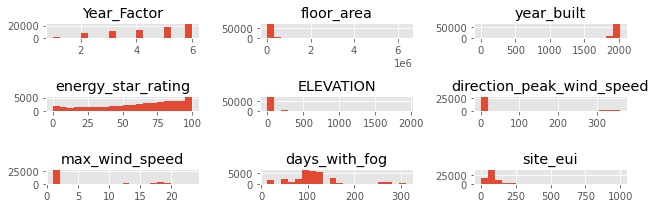

In [11]:
numerical = ['Year_Factor', 'floor_area', 'year_built','energy_star_rating', 'ELEVATION',
             'direction_peak_wind_speed','max_wind_speed', 'days_with_fog', 'site_eui']
num_df[numerical].hist(bins=20, layout=(3,3), figsize=(9,3))
plt.tight_layout()
plt.show()

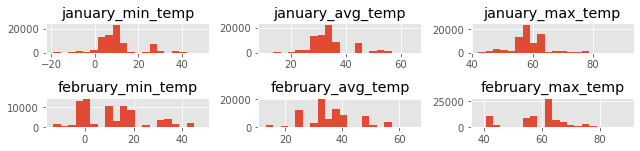

In [12]:
numerical = ['january_min_temp', 'january_avg_temp', 'january_max_temp',
             'february_min_temp', 'february_avg_temp','february_max_temp']
num_df[numerical].hist(bins=20, layout=(3,3), figsize=(9,3))
plt.tight_layout()
plt.show()

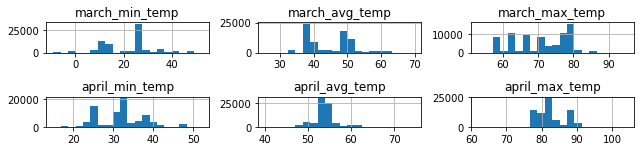

In [18]:
numerical = ['march_min_temp', 'march_avg_temp', 'march_max_temp',
             'april_min_temp', 'april_avg_temp','april_max_temp']
num_df[numerical].hist(bins=20, layout=(3,3), figsize=(9,3))
plt.tight_layout()
plt.show()

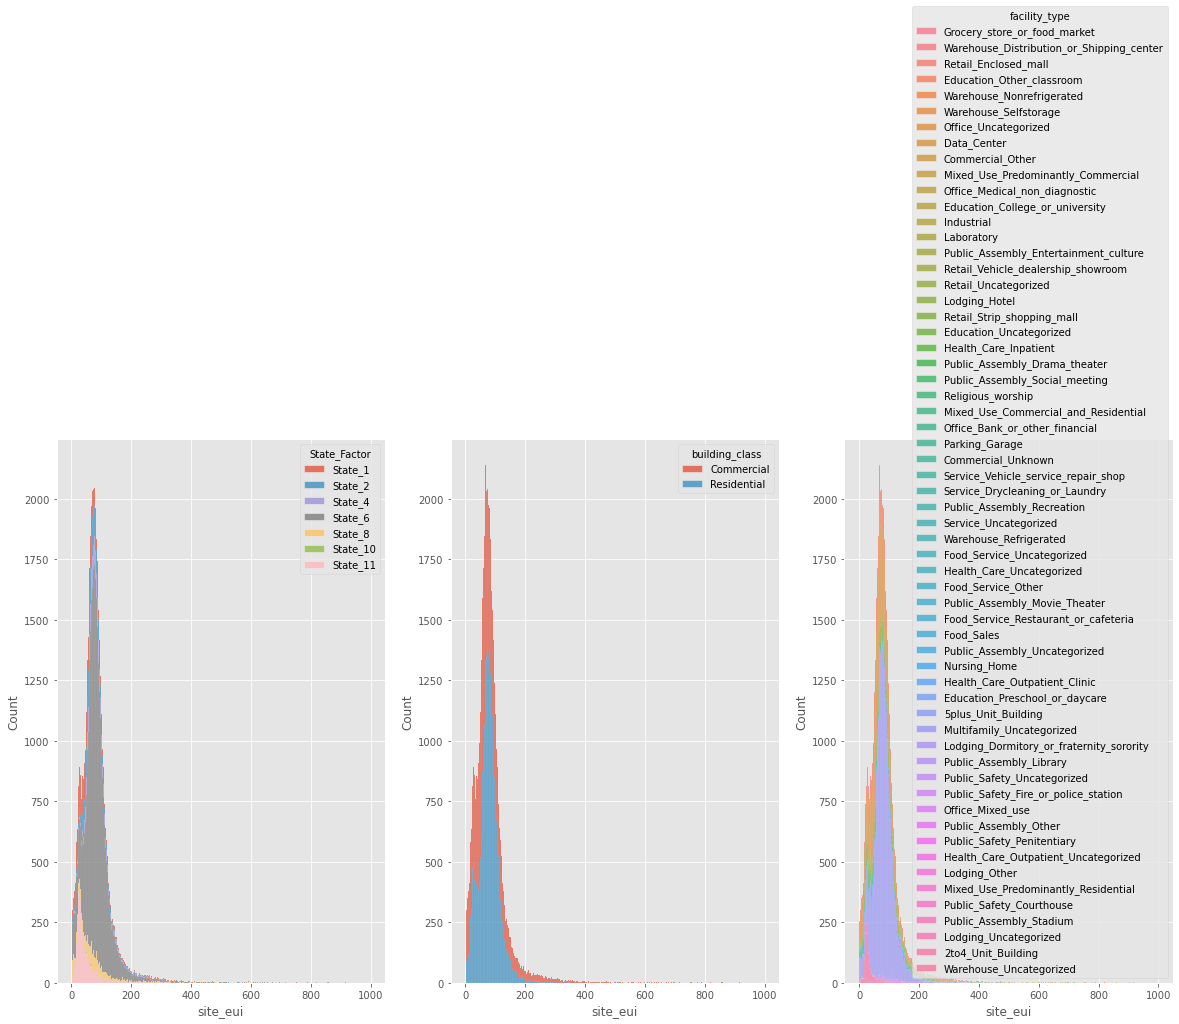

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for variable, ax in zip(categorical_features, axs.flatten()):
    sns.histplot(train, x='site_eui', hue=variable, multiple='stack', ax=ax)

Text(0.5, 1.0, 'Missing values in training Data')

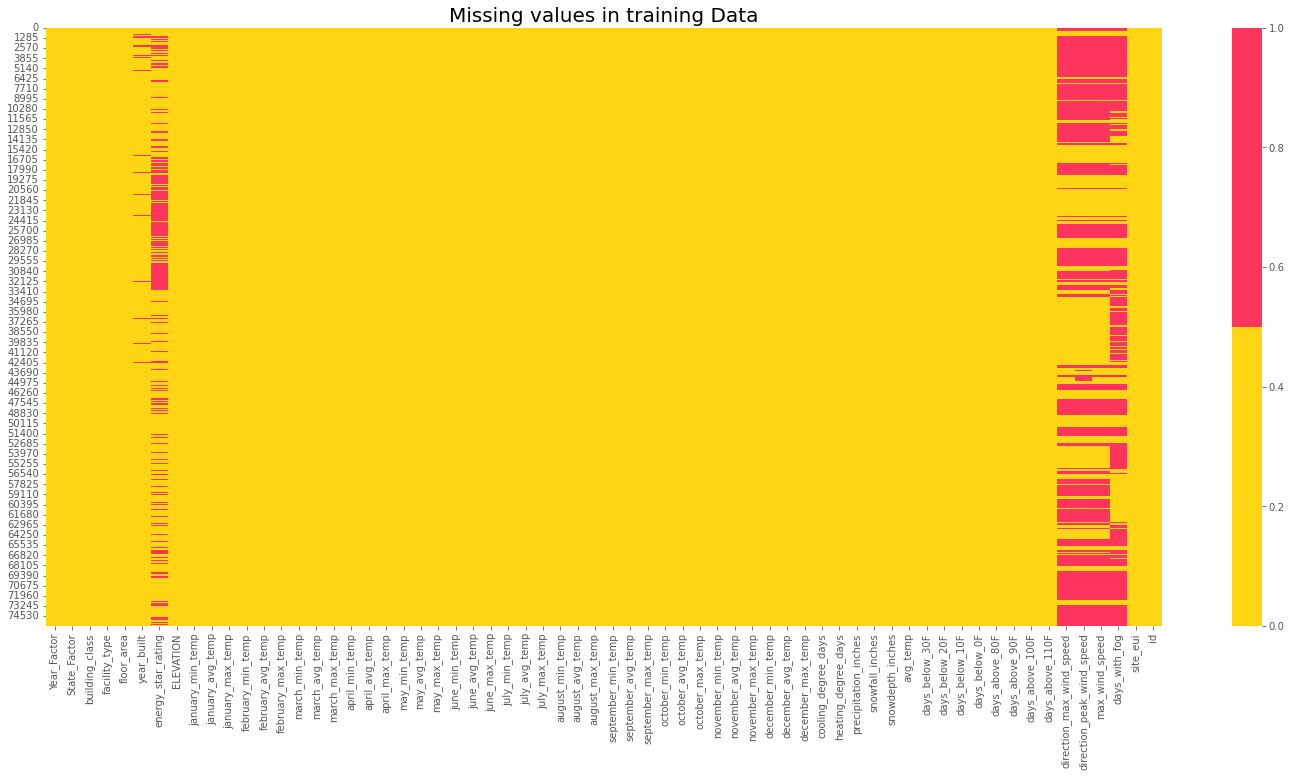

In [14]:
# https://www.kaggle.com/usharengaraju/wids2022-lgbm-starter-w-b
plt.figure(figsize=(25, 11))
sns.heatmap(train.isna().values, 
            cmap=['#ffd514','#ff355d'], xticklabels=train.columns)
plt.title("Missing values in training Data", size=20)

In [35]:
#code copied from https://www.kaggle.com/shrutisaxena/wids2022-starter-code
missing_columns = [col for col in train.columns if train[col].isnull().any()]
missingvalues_count =train.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]
missingValues_df.style.background_gradient(cmap="Pastel1")

,Null Values Count
year_built,1837
energy_star_rating,26709
direction_max_wind_speed,41082
direction_peak_wind_speed,41811
max_wind_speed,41082
days_with_fog,45796


In [16]:
train.describe().style.background_gradient(cmap="Pastel1")

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,75757.000000,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,165983.865858,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,58.486278,21.606281,44.469292,70.897831,32.037171,53.784863,82.661932,44.706179,63.742547,88.987856,51.131763,71.066384,91.400280,60.571604,76.596879,95.543950,58.515068,75.348749,92.572581,50.791689,69.597545,92.171139,38.210911,58.727038,81.135671,28.630397,48.123133,71.202397,22.736777,41.625569,64.496852,1202.250446,4324.957390,42.430651,29.136379,164.862455,56.176705,48.756511,17.447932,4.886532,0.876764,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,246875.790940,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,8.414611,10.004303,6.657142,7.680982,5.577279,2.500473,4.101028,4.200319,2.792919,2.864669,3.415926,2.861681,3.604068,4.177109,4.090275,4.157118,4.441992,3.818895,4.139685,4.290884,3.603773,5.011708,5.093899,2.641300,5.579513,7.153244,4.094207,4.373374,9.014047,5.869386,6.054104,391.561780,824.366727,10.592205,17.810894,175.275869,2.241940,27.587124,14.469435,7.071221,2.894244,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,943.000000,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,38.000000,-9.000000,25.854839,53.000000,15.000000,40.280000,62.000000,23.000000,46.950000,64.000000,30.000000,54.100000,67.000000,37.000000,54.822581,65.000000,31.000000,56.693548,66.000000,26.000000,53.600000,64.000000,18.000000,44.693548,59.000000,4.000000,30.766667,53.000000,-16.000000,23.790323,42.000000,0.000000,398.000000,0.000000,0.000000,0.000000,44.512329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,62379.000000,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,55.000000,13.000000,38.096774,62.000000,26.000000,52.333333,80.000000,42.000000,62.790323,88.000000,50.000000,70.983333,89.000000,57.000000,76.145161,95.000000,57.000000,74.516129,90.000000,47.000000,68.200000,91.000000,35.000000,58.048387,78.000000,23.000000,45.250000,69.000000,17.000000,38.532258,60.000000,1128.000000,3978

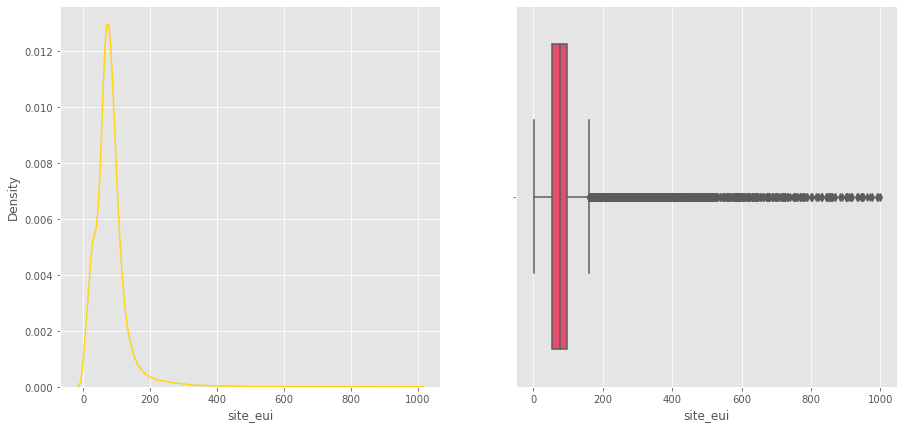

In [17]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
sns.kdeplot(train.site_eui , color = "#ffd514")
plt.subplot(122)
sns.boxplot(train.site_eui , color = "#ff355d");

In [57]:
# year_built: replace with current year.
train['year_built'] = train['year_built'].replace(np.nan, 2022)
# energy_star_rating: replace with mean.
train['energy_star_rating'] = train['energy_star_rating'].\
replace(np.nan, train['energy_star_rating'].mean())
# direction_max_wind_speed, direction_peak_wind_speed, max_wind_speed: 
# replace with 1 with since 25, 50 75 percentiles are all 1.
train['direction_max_wind_speed'] = \
train['direction_max_wind_speed'].replace(np.nan, 1)
train['direction_peak_wind_speed'] = \
train['direction_peak_wind_speed'].replace(np.nan, 1)
train['max_wind_speed'] = train['max_wind_speed'].replace(np.nan, 1)
# energy_star_rating: replace with mean.
train['days_with_fog'] = train['days_with_fog'].replace(np.nan,
                                                        train['days_with_fog'].mean())
# test data
# year_built: replace with current year.
test['year_built'] = test['year_built'].replace(np.nan, 2022)
# energy_star_rating: replace with mean.
test['energy_star_rating'] = test['energy_star_rating'].\
replace(np.nan, test['energy_star_rating'].mean())
# direction_max_wind_speed, direction_peak_wind_speed, max_wind_speed: 
# replace with 1 with since 25, 50 75 percentiles are all 1.
test['direction_max_wind_speed'] = \
test['direction_max_wind_speed'].replace(np.nan, 1)
test['direction_peak_wind_speed'] = \
test['direction_peak_wind_speed'].replace(np.nan, 1)
test['max_wind_speed'] = test['max_wind_speed'].replace(np.nan, 1)
# energy_star_rating: replace with mean.
test['days_with_fog'] = test['days_with_fog'].replace(np.nan,
                                                      test['days_with_fog'].mean())

In [58]:
# handling categorical fields
le = LabelBinarizer()
train = pd.get_dummies(train, columns=['building_class'])
test = pd.get_dummies(test, columns=['building_class'])

train['State_Factor']= le.fit_transform(train['State_Factor']).astype("uint8")
test['State_Factor']= le.fit_transform(test['State_Factor']).astype("uint8")
train['facility_type']= le.fit_transform(train['facility_type']).astype("uint8")
test['facility_type']= le.fit_transform(test['facility_type']).astype("uint8")

In [59]:
feat = [col for col in train.columns if col not in ["id", "site_eui"]]
X = train[feat]
y = train["site_eui"]

X_test = test[feat]

In [60]:
import copy
trainnames = copy.deepcopy(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)

In [67]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=2000,
                          iterations=28000,
                          early_stopping_rounds=10,
                          random_seed=42,
                          max_depth=12,
                          task_type='GPU',
                          learning_rate=0.025,
                          eval_metric='RMSE',
                          loss_function='RMSE'
                        )

model.fit(X_train, y_train)

0:	learn: 57.7796958	total: 70.1ms	remaining: 32m 41s
2000:	learn: 35.5088615	total: 2m 3s	remaining: 26m 39s
4000:	learn: 29.6048156	total: 4m 6s	remaining: 24m 39s
6000:	learn: 25.7570846	total: 6m 11s	remaining: 22m 40s
8000:	learn: 23.0131718	total: 8m 16s	remaining: 20m 40s
10000:	learn: 20.9380288	total: 10m 21s	remaining: 18m 38s
12000:	learn: 19.3502462	total: 12m 27s	remaining: 16m 35s
14000:	learn: 18.0804041	total: 14m 33s	remaining: 14m 32s
16000:	learn: 17.0644254	total: 16m 38s	remaining: 12m 29s
18000:	learn: 16.2340539	total: 18m 44s	remaining: 10m 24s
20000:	learn: 15.5345335	total: 20m 48s	remaining: 8m 19s
22000:	learn: 14.9437400	total: 22m 53s	remaining: 6m 14s
24000:	learn: 14.4464241	total: 24m 58s	remaining: 4m 9s
26000:	learn: 14.0229380	total: 27m 3s	remaining: 2m 4s
27999:	learn: 13.6539765	total: 29m 8s	remaining: 0us


In [78]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
y_pred_class_rf = model.predict(X_val)
# y_pred_prob_rf = model.predict_proba(X_val)


print('rmse is {:.3f}'.format(np.sqrt(mean_squared_error(y_val,y_pred_class_rf))))
# print('roc-auc is {:.3f}'.format(roc_auc_score(y_val,y_pred_prob_rf[:,1])))

rmse is 50.185


In [71]:
y_pred_class_rf

array([ 92.69536342,  63.39542656,  75.27662977, ..., 217.69735783,
       113.53973622,  40.84313816])

In [76]:
# preds = np.mean(np.column_stack(predictions), axis=1)
preds = model.predict(X_test)
sub = pd.DataFrame(columns = ['id', 'site_eui'])
sub['id'] = test['id']
sub['site_eui'] = preds
sub

,id,site_eui
0,75757,153.446430
1,75758,148.469006
2,75759,181.164542
3,75760,172.399209
4,75761,212.639349
...,...,...
9700,85457,28.081539
9701,85458,62.911619
9702,85459,55.020442
9703,85460,66.231086


In [77]:
sub.to_csv("submission1.csv", index=False)